In [1]:
import pandas as pd
import pickle
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl
from cellink.tl._burden_testing import *

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chr22_all_results_CD8_ET=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr22_all_results_CD8_ET.pkl"
                                       )

In [3]:
chr22_all_results_CD8_ET

burden_gene      target_gene              burden_type    pvalue  \
0   ENSG00000100181  ENSG00000100181               CADD_PHRED  0.343741   
1   ENSG00000100181  ENSG00000100181                DNA_LM_up  0.544808   
2   ENSG00000100181  ENSG00000100181              DNA_LM_down  0.431294   
3   ENSG00000100181  ENSG00000100181            MAF_beta_1.25  0.482730   
4   ENSG00000100181  ENSG00000100181             DNA_LM_mixed  0.538777   
..              ...              ...                      ...       ...   
2   ENSG00000079974  ENSG00000079974              DNA_LM_down  0.543083   
3   ENSG00000079974  ENSG00000079974            MAF_beta_1.25  0.791838   
4   ENSG00000079974  ENSG00000079974             DNA_LM_mixed  0.543083   
5   ENSG00000079974  ENSG00000079974        GENE_TSS_DISTANCE  0.630698   
6   ENSG00000079974  ENSG00000079974  GENE_TSS_DISTANCE_SAIGE  0.142502   

        beta cell_type chromosome  
0  -0.002834    CD8 ET         22  
1  -0.001817    CD8 ET         22  
2  -0.002365    CD8 ET         22  
3  -0.002114    CD8 ET         22  
4  -0.001844    CD8 ET         22  
..       ...       ...        ...  
2   0.005432    CD8 ET         22  
3   0.002362    CD8 ET         22  
4   0.005432    CD8 ET         22  
5   0.004284    CD8 ET         22  
6  -0.013045    CD8 ET         22  

[2583 rows x 7 columns]

### Correcting p values

In [4]:
from statsmodels.stats.multitest import multipletests

In [69]:
def FDR_correction(association_results):
    """
    association_results: pd.DataFrame, results from burden_test/ output written in run_burden_ass.py
    
    returns: - df_final: pd.DataFrame, association_results, sorted by celltype and burden type
                                        added column "FDR corrected" values and "significant"
             - df_to_plot: pd.DataFrame, summary of # significant egenes per cell type and burden type
    """
   
    df=association_results.copy()
    df_to_plot = pd.DataFrame(columns=['celltype', 'annotation', 'n'])
    
    df_final=[]
    for celltype in df["cell_type"].unique():
        df_annotations={}
        for annotation in df["burden_type"].unique():
            df_annotations[annotation] = df[(df["cell_type"] == celltype) & (df["burden_type"]==annotation)]
            df_annotations[annotation] = df_annotations[annotation].dropna(how='all')
            # FDR correction
            df_annotations[annotation]["significant"], df_annotations[annotation]["FDR_corrected"], _, _ = multipletests(df_annotations[annotation]["pvalue"], alpha=0.05, method='fdr_bh')
            
            df_to_plot = pd.concat([df_to_plot, pd.DataFrame({
                    'celltype': [celltype],
                    'annotation': [annotation],
                    'n': [len(df_annotations[annotation][df_annotations[annotation]["significant"]])]
                })], ignore_index=True)
            df_annotations[annotation]["celltype-annotation"]= f"{celltype}-{annotation}"
            df_final.append(df_annotations[annotation]) 
            
    df_final=pd.concat(df_final)
    
    df_to_plot['celltype_annotation'] = df_to_plot['celltype'] + "_" + df_to_plot['annotation']
    df_to_plot
    return df_final, df_to_plot
        

In [32]:
from plotnine import *
def plot_egenes(df_to_plot):
    """
    df_to_plot: pd.DataFrame, as output[1] of  FDR_correction()
    returns: plot, grouped barplot # egenes per cell type and burden
    """
    zero_types = list(df_to_plot.query("n==0")["celltype_annotation"])
    # Filter out the rows where `n` is 0 and create the plot
    plot = (
        ggplot(df_to_plot.query("celltype_annotation not in @zero_types"), 
               aes(x='celltype', y='n', fill='annotation'))  # Specify x, y, and fill variables
        + geom_bar(stat="identity", position="dodge")  # Use position="dodge" for grouped bars
        + theme_classic()  # Optional: use a clean theme
        + theme(
            axis_text_x=element_text(angle=45, hjust=1, vjust=1),
            figure_size=(7, 4)
        )
        + labs(
            y="Number of E-Genes", 
            x="", 
            fill="Burden Annotation"
        )
        # Optional: Customize colors manually
        # + scale_fill_manual(values=['darkred', "grey", "blue", "green"], 
        #     labels=["GENE_TSS_DISTANCE", "GENE_TSS_DISTANCE_SAIGE", "CADD_PHRED", "DNA_LM_down","DNA_LM_up","DNA_LM_mixed", "MAF_beta_1.25"])
    )
    return(plot)


In [70]:
df_final_ET, df_to_plot_ET = FDR_correction(chr22_all_results_CD8_ET)

In [43]:
df_final_ET.head()

burden_gene      target_gene burden_type    pvalue      beta cell_type  \
0  ENSG00000100181  ENSG00000100181  CADD_PHRED  0.343741 -0.002834    CD8 ET   
0  ENSG00000237438  ENSG00000237438  CADD_PHRED  0.597237  0.000659    CD8 ET   
0  ENSG00000177663  ENSG00000177663  CADD_PHRED  0.182670  0.010247    CD8 ET   
0  ENSG00000069998  ENSG00000069998  CADD_PHRED  0.452943  0.006836    CD8 ET   
0  ENSG00000185837  ENSG00000185837  CADD_PHRED  0.250249 -0.001151    CD8 ET   

  chromosome  significant  FDR_corrected celltype-annotation  
0         22        False       0.946734   CD8 ET-CADD_PHRED  
0         22        False       0.963597   CD8 ET-CADD_PHRED  
0         22        False       0.871925   CD8 ET-CADD_PHRED  
0         22        False       0.963597   CD8 ET-CADD_PHRED  
0         22        False       0.932746   CD8 ET-CADD_PHRED

In [18]:
df_to_plot_ET

celltype               annotation  n             celltype_annotation
0   CD8 ET               CADD_PHRED  0               CD8 ET_CADD_PHRED
1   CD8 ET                DNA_LM_up  0                CD8 ET_DNA_LM_up
2   CD8 ET              DNA_LM_down  0              CD8 ET_DNA_LM_down
3   CD8 ET            MAF_beta_1.25  0            CD8 ET_MAF_beta_1.25
4   CD8 ET             DNA_LM_mixed  0             CD8 ET_DNA_LM_mixed
5   CD8 ET        GENE_TSS_DISTANCE  1        CD8 ET_GENE_TSS_DISTANCE
6   CD8 ET  GENE_TSS_DISTANCE_SAIGE  1  CD8 ET_GENE_TSS_DISTANCE_SAIGE

[2025-01-24 09:40:47,222] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


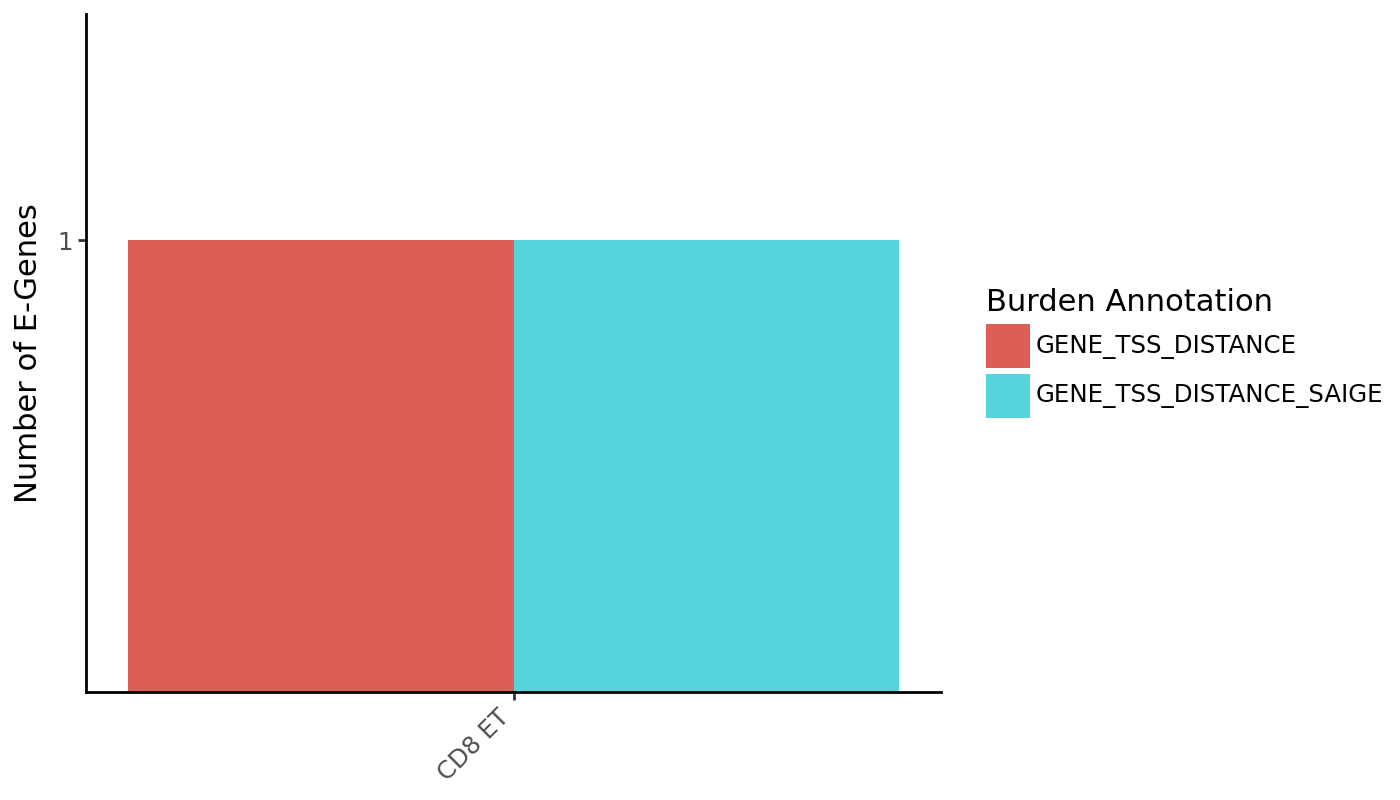

In [33]:
plot_egenes(df_to_plot_ET)

## QQ plots for burden type

In [46]:
def QQ_plot_sig_egenes(FDR_corrected_results, burdentype):
    """
    FDR_corrected_results: pd.DataFrame, output[0] of FDR_correction()
    burdentype: Str

    returns: QQ plot for given burden. Red line: uniform distributed pvalues. 
                                        in red: significant egens
    """
    df = FDR_corrected_results.copy().query("burden_type == @burdentype")

    df = df.sort_values("pvalue")
    df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))
    
    if "-log10pval" not in df.columns:
        df["-log10pval"] = -np.log10(df["pvalue"])
    
    aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
    plot = (
        ggplot(df, aes(**aes_kwargs, color="significant"))
        + labs(title="QQ plot")
        + scale_color_manual(values = ["black", "red"])
        + theme_classic()
        + geom_abline(intercept=0, slope=1, color="red")
        + geom_point()
        + theme(legend_position="top", figure_size = (3,3))
    )
    return(plot)

[2025-01-24 09:47:25,011] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


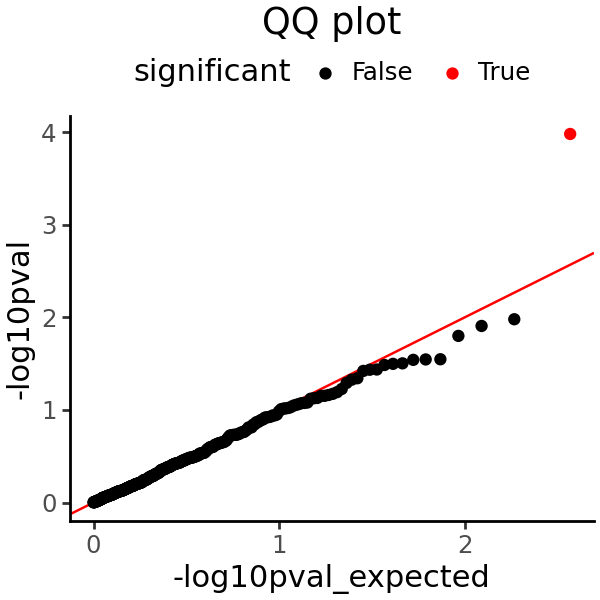

In [47]:
QQ_plot_sig_egenes(df_final_ET, "GENE_TSS_DISTANCE")

[2025-01-24 09:48:52,159] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


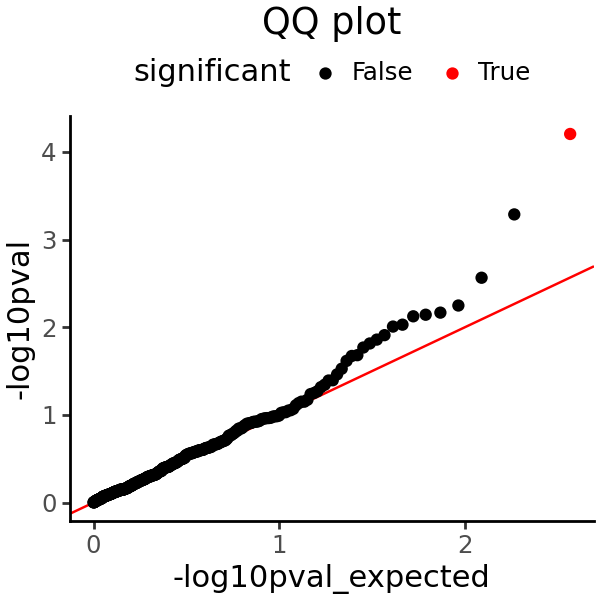

In [49]:
QQ_plot_sig_egenes(df_final_ET, "GENE_TSS_DISTANCE_SAIGE")

## Pseudobulk computation and plot recreation
-> for cell type "CD8 ET"

In [51]:

from cellink.tl._eqtl import _get_pb_data

In [73]:
def get_pb_data_for_ct_per_gene(data, all_burdens, eigenvec, celltype, target_chrom):
    """
    data: DonorData object, annotated (output from run_data_annotation.py)
    all_burdens: pd.DataFrame, computed burden scores (output from run_compute_burdens.py)
    eigenvec: pd.DataFrame 
                (eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)
    celltype: Str, cell type for which pb are computed
    target_chrom: Str

    returns: pb_by_gene_df, pd.DataFrame: sample id, pb_geneexpressions
    """
    eigenvec.index = eigenvec[1]
    eigenvec = eigenvec.iloc[:, 2:]
    eigenvec = eigenvec[eigenvec.index.isin(all_burdens.index.unique())]

    pb_data=_get_pb_data(
        scdata=data.adata,
        gdata=data.gdata,
        cell_type= celltype,
        target_chromosome= target_chrom,
        donor_key_in_scdata = "individual",
        sex_key_in_scdata = "sex",
        age_key_in_scdata = "age",
        pseudobulk_aggregation_type= "mean",
        min_individuals_threshold= 10,
        n_top_genes = 5_000,
        n_sc_comps= 15,
        n_genetic_pcs= 20,
        n_cellstate_comps= 50,
        eigenvector_df=eigenvec
    )
    
    pb_data_all_genes = pb_data.adata.layers["mean"]
    pb_by_gene_df = pd.DataFrame(pb_data_all_genes, columns=pb_data.adata.var_names, index=pb_data.adata.obs_names)
    
    return(pb_by_gene_df)
    

In [116]:
def burdenscore_with_pb_expression(pb_by_gene_df, geneid, all_burdens, burden_type, celltype):
    """
    for a given gene, burdentype and celltype: combined info in one dataframe
    
    pb_by_gene_df: pd.DataFrame (output, get_pb_data_for_ct_per_gene)
    geneid: str
    all_burdens: pd.DataFrame, computed burden scores (output from run_compute_burdens.py)
    burden_type: Str
    celltype: Str (musst be the same as used in get_pb_data_for_ct_per_gene)

    returns: pd.DataFrame, cols: burdenscores, pb_expr, celltype
    """
    burden_type_gene=pd.DataFrame(all_burdens[all_burdens["Geneid"]==geneid][burden_type])
    # add pb expr
    burden_type_gene["pb_expr"]=pb_by_gene_df[geneid]
    burden_type_gene["cell_type"]= celltype
    return(burden_type_gene)
    

In [117]:
def plot_burden_expre_corr(burden_type_gene, burden_type):
    """
    plots the relation between pb expression and the burden score

    burden_type_gene:  pd.DataFrame (output, burdenscore_with_pb_expression, 
                            can be concatinated for multiple cell types)
    burden_type: Str 
    """
    plot = (
        ggplot(burden_type_gene, aes(x = burden_type, y = "pb_expr"))
        + labs(x = "Gene score")
        + theme_classic()
        + geom_smooth()
        + geom_point()
        + facet_wrap("cell_type", scales = "free")
        + theme(legend_position="top", figure_size = (4.5,3))
    )
    plot
    return(plot)

In [103]:
data_chr22 = pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/annotations/chr22_data.pkl")

chr22_all_burdens_CD8_ET = pd.read_parquet("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/burdens/chr22_all_burdens_CD8_ET.parquet")

eigenvec = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/input_data/pcdir/wgs.dose.filtered.R2_0.8.filtered.pruned.eigenvec", sep=' ', header=None)


In [104]:
pb_by_gene_df= get_pb_data_for_ct_per_gene(data_chr22, chr22_all_burdens_CD8_ET, eigenvec, "CD8 ET", "22")


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


[2025-01-24 10:52:52,595] INFO:cellink._core.donordata: Keeping 981/981 donors
[2025-01-24 10:52:52,596] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2025-01-24 10:52:52,596] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:219: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


In [121]:
burdens_expr = burdenscore_with_pb_expression(pb_by_gene_df, "ENSG00000100181", chr22_all_burdens_CD8_ET, "GENE_TSS_DISTANCE", "CD8 ET")
burdens_expr

GENE_TSS_DISTANCE   pb_expr cell_type
id                                              
1_1             5.747291e+10  0.092711    CD8 ET
2_2             5.994206e+10  0.061852    CD8 ET
3_3             5.098237e+10  0.031793    CD8 ET
4_4             6.204657e+10  0.038197    CD8 ET
6_6             5.249046e+10  0.000000    CD8 ET
...                      ...       ...       ...
1077_1078       5.289689e+10  0.079500    CD8 ET
1078_1079       5.977347e+10  0.000000    CD8 ET
1079_1080       5.895898e+10  0.115054    CD8 ET
1080_1081       5.277882e+10  0.072514    CD8 ET
1081_1082       5.793235e+10  0.080598    CD8 ET

[981 rows x 3 columns]

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


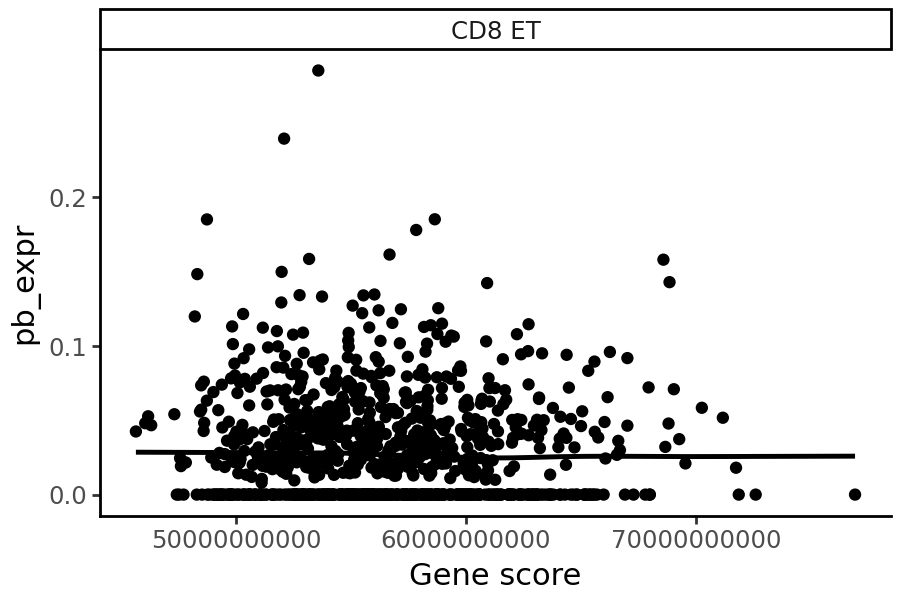

In [120]:
# here: multiple dfs of type burdens_expr could be concatinated
plot_burden_expre_corr(burdens_expr, burden_type="GENE_TSS_DISTANCE")